In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
trader_df = pd.read_csv('historical_data.csv')
sentiment_df = pd.read_csv('fear_greed_index.csv')

In [4]:
trader_df.head()
sentiment_df.head()


,timestamp,value,classification,date
0,1517463000,30,Fear,2018-02-01
1,1517549400,15,Extreme Fear,2018-02-02
2,1517635800,40,Fear,2018-02-03
3,1517722200,24,Extreme Fear,2018-02-04
4,1517808600,11,Extreme Fear,2018-02-05


In [8]:
trader_df['Timestamp IST'] = pd.to_datetime(
    trader_df['Timestamp IST'],
    format='%d-%m-%Y %H:%M'
)

trader_df['date'] = trader_df['Timestamp IST'].dt.date


In [10]:
numeric_cols = [
    'Execution Price',
    'Size Tokens',
    'Size USD',
    'Start Position',
    'Closed PnL',
    'Fee'
]

for col in numeric_cols:
    trader_df[col] = pd.to_numeric(trader_df[col], errors='coerce')


In [11]:
sentiment_df['date'] = pd.to_datetime(sentiment_df['date']).dt.date
sentiment_df['classification'] = sentiment_df['classification'].str.lower()
sentiment_df['classification'] = sentiment_df['classification'].replace({
    'extreme fear': 'fear',
    'extreme greed': 'greed'
})


In [12]:
daily_metrics = trader_df.groupby('date').agg(
    total_trades=('Account', 'count'),
    total_volume_usd=('Size USD', 'sum'),
    avg_trade_size=('Size USD', 'mean'),
    total_pnl=('Closed PnL', 'sum'),
    total_fees=('Fee', 'sum'),
    win_rate=('Closed PnL', lambda x: (x > 0).mean())
).reset_index()


In [13]:
merged_df = daily_metrics.merge(
    sentiment_df[['date', 'classification']],
    on='date',
    how='inner'
)


In [14]:
merged_df.rename(columns={'classification': 'sentiment'}, inplace=True)


In [15]:
print(merged_df.head())
print(merged_df.shape)


         date  total_trades  total_volume_usd  avg_trade_size   total_pnl  \
0  2023-05-01             3            477.00      159.000000    0.000000   
1  2023-12-05             9          50005.83     5556.203333    0.000000   
2  2023-12-14            11         113203.35    10291.213636 -205.434737   
3  2023-12-15             2          10609.95     5304.975000  -24.632034   
4  2023-12-16             3          15348.77     5116.256667    0.000000   

   total_fees  win_rate sentiment  
0    0.000000  0.000000     greed  
1   12.501455  0.000000     greed  
2   28.300831  0.363636     greed  
3    2.652489  0.000000     greed  
4    3.837189  0.000000     greed  
(479, 8)


In [16]:
merged_df.to_csv('merged_data.csv', index=False)


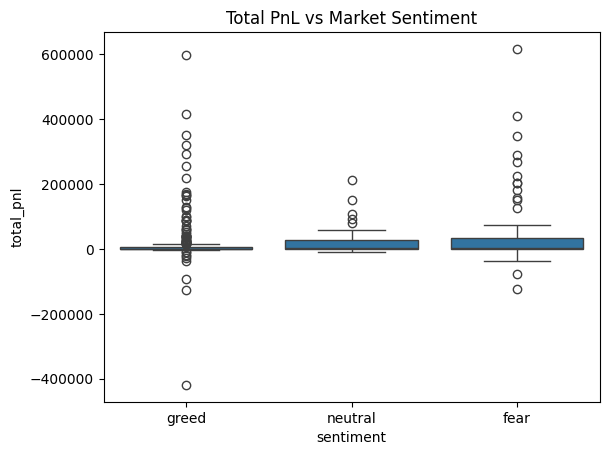

In [22]:
sns.boxplot(data=merged_df, x='sentiment', y='total_pnl')
plt.title('Total PnL vs Market Sentiment')
plt.savefig('pnl_vs_sentiment.png')
plt.show()


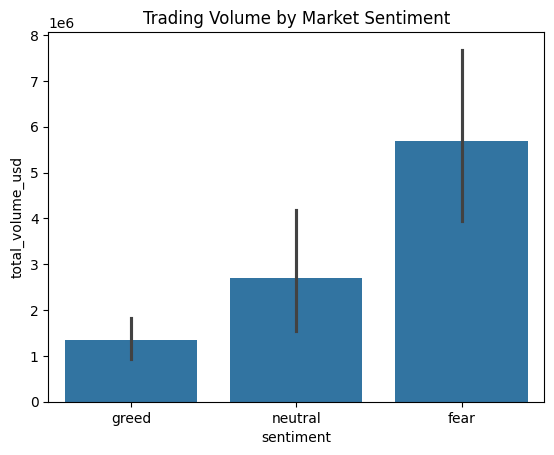

In [23]:
sns.barplot(data=merged_df, x='sentiment', y='total_volume_usd')
plt.title('Trading Volume by Market Sentiment')
plt.savefig('trade_volume_sentiment.png')
plt.show()


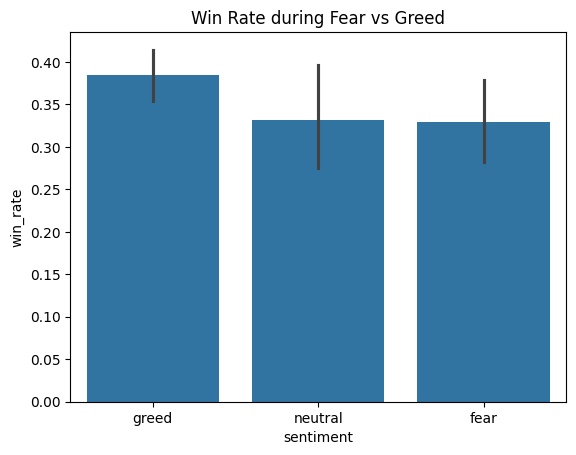

In [24]:
sns.barplot(data=merged_df, x='sentiment', y='win_rate')
plt.title('Win Rate during Fear vs Greed')
plt.savefig('win_rate_fear_vs_greed.png')
plt.show()
